# SPAM Detection

We will use word embeddings

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Load dataset
df = pd.read_csv('../input/sms-spam-collection-dataset/spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


There are three unnecesarry columns, we will only stay with v1 and v2

In [3]:
df = df[['v1','v2']].rename(columns = {'v1':'label', 'v2':'mail'})
df.head()

,label,mail
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Ham means there's no spam and spam means there is, so we will map those values to 0 and 1 respectively.

In [4]:
df['label'] = df['label'].map({'ham':0, 'spam':1})
df.head()

,label,mail
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# Amount of each label
df['label'].value_counts()

label
0    4825
1     747
Name: count, dtype: int64

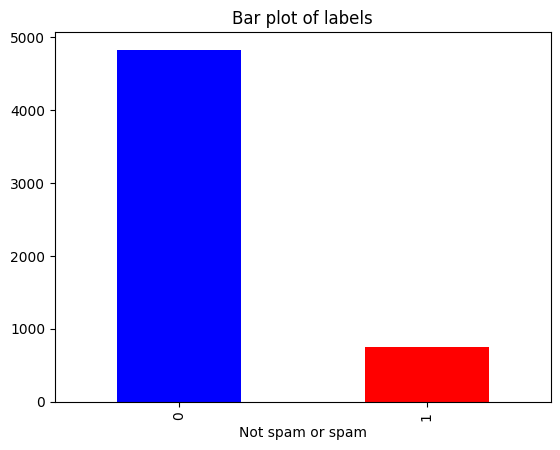

In [6]:
# Graph of labels
import matplotlib.pyplot as plt
ax = df['label'].value_counts().sort_index().plot(kind = 'bar', color = ['blue', 'red'])
ax.set_title('Bar plot of labels')
ax.set_xlabel('Not spam or spam');

In [7]:
# We will now divide between training and testing sets
from sklearn.model_selection import train_test_split

training_mails, testing_mails, training_labels, testing_labels = train_test_split(df['mail'], df['label'], test_size = 0.2, random_state = 42, stratify = df['label'])

In [8]:
# Define variables
vocab_size = 100000
max_length = 32
trunc_type = 'post'
embedding_dim = 16
pad_type = 'post'
oov_tok = "<OOV>"

In [9]:
training_mails = training_mails.values
testing_mails = testing_mails.values
training_labels = training_labels.values
testing_labels = testing_labels.values

In [10]:
# Divide also padded sets
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_mails)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_mails)
training_padding = pad_sequences(training_sequences, maxlen = max_length,
                                truncating = trunc_type, padding = pad_type)

testing_sequences = tokenizer.texts_to_sequences(testing_mails)
testing_padding = pad_sequences(testing_sequences, maxlen = max_length, 
                               truncating = trunc_type, padding = pad_type)

In [11]:
# Necessary for tf
import numpy as np
training_padding = np.array(training_padding)
training_labels = np.array(training_labels)
testing_padding = np.array(testing_padding)
testing_labels = np.array(testing_labels)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [13]:
# Fit the data
num_epochs = 30
model.fit(training_padding, training_labels, validation_data = (testing_padding, testing_labels), epochs = num_epochs,
         verbose = 2)

Epoch 1/30
140/140 - 4s - loss: 0.4825 - accuracy: 0.8454 - val_loss: 0.2639 - val_accuracy: 0.8673 - 4s/epoch - 27ms/step
Epoch 2/30
140/140 - 2s - loss: 0.1854 - accuracy: 0.9201 - val_loss: 0.1418 - val_accuracy: 0.9578 - 2s/epoch - 16ms/step
Epoch 3/30
140/140 - 2s - loss: 0.0966 - accuracy: 0.9751 - val_loss: 0.0852 - val_accuracy: 0.9776 - 2s/epoch - 17ms/step
Epoch 4/30
140/140 - 2s - loss: 0.0545 - accuracy: 0.9854 - val_loss: 0.0609 - val_accuracy: 0.9839 - 2s/epoch - 16ms/step
Epoch 5/30
140/140 - 2s - loss: 0.0357 - accuracy: 0.9892 - val_loss: 0.0517 - val_accuracy: 0.9839 - 2s/epoch - 16ms/step
Epoch 6/30
140/140 - 2s - loss: 0.0256 - accuracy: 0.9919 - val_loss: 0.0453 - val_accuracy: 0.9865 - 2s/epoch - 16ms/step
Epoch 7/30
140/140 - 2s - loss: 0.0190 - accuracy: 0.9946 - val_loss: 0.0437 - val_accuracy: 0.9874 - 2s/epoch - 16ms/step
Epoch 8/30
140/140 - 2s - loss: 0.0145 - accuracy: 0.9960 - val_loss: 0.0415 - val_accuracy: 0.9874 - 2s/epoch - 16ms/step
Epoch 9/30
140/1

In [14]:
# Examples
sentence = ["A vulnerability has been identified in the Apple Mobile Facetime Applications, click here to do a facetime verification",
            "You have won a free trip, just click here to claim your price",
           "Check our new Nike offers for this black friday"]
sequences = tokenizer.texts_to_sequences(sentence)
padding = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type, padding = pad_type)
predictions = model.predict(padding)
print(predictions)

1/1 [==============================] - 0s 110ms/step
[[0.58455354]
 [0.99500173]
 [0.04853683]]
